In [1]:
import dgl
from torch_geometric.datasets import planetoid
from torch_geometric.utils import to_networkx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

d:\ProgramData\Anaconda3\envs\rwn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [66]:
PubMed = planetoid.Planetoid('./Problem5', 'Pubmed')
pubmed = PubMed[0]
pubmed = to_networkx(pubmed, pubmed.node_attrs(), to_undirected=pubmed.is_undirected())
pubmed = dgl.from_networkx(pubmed, node_attrs=list(pubmed.nodes[0].keys()))

tensor([    0,  6092,  8302,  6092,  7191,  5830,  7191,  9113,  8772, 12664,
        10846, 10911, 10846, 16684,  1469,   928, 18811,  6185, 14454, 11816,
        18552, 11816,  8697,  6081, 12049,  1629,  5602,  9797, 17839, 10185,
         9264, 10185])

In [ ]:
out = dgl.sampling.node2vec_random_walk(pubmed, 
                                  nodes=np.arange(pubmed.num_nodes()), 
                                  p=1.6, 
                                  q=1.6, 
                                  walk_length=31)
out[0] # Example of the random walk that started from node 0

For this random walk I used p = q = 1.6; these values were chosen arbitrarily, but if I were to need to tune the parameters it would depend on how important communities were to my application. The more I need node embeddings to be representative of their respective communities, I would choose a higher p-value and a lower q-value.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


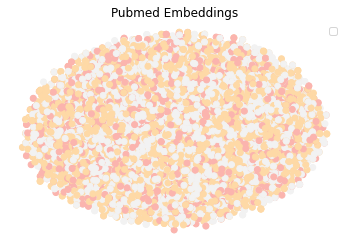

In [68]:
tsne = TSNE(n_components=2, init='random')
emb = tsne.fit_transform(out)
labels = PubMed[0].y.numpy()
plt.scatter(emb[:,0], emb[:,1], c = labels, cmap='Pastel1')
# plt.axis('off')
plt.title('Pubmed Embeddings')
plt.show()

Clearly, these embeddings do not provide adequate separation of classes by themselves. However, we can apply a GCN to these embeddings to improve separation and greatly increase accuracy, which is shown in the next section

In [32]:

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Basic Graph Convolutional Network
class GCN(torch.nn.Module):
    def __init__(self, n_features, n_classes, n_channels=32, seed=42):
        super().__init__()
        torch.manual_seed(seed)
        self.conv1 = GCNConv(n_features, n_channels)
        self.conv2 = GCNConv(n_channels, n_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


def train_epoch(model, optimizer, criterion, dataset):
    model.train()
    optimizer.zero_grad()
    out = model(dataset.x, dataset.edge_index)
    loss = criterion(out[dataset.train_mask], dataset.y[dataset.train_mask])
    loss.backward()
    optimizer.step()
    pred = out.argmax(dim=1)
    acc = pred[dataset.train_mask] == dataset.y[dataset.train_mask]
    acc = acc.sum() / len(acc)
    return loss, acc

def test(model, dataset):
    model.eval()
    out = model(dataset.x, dataset.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[dataset.test_mask] == dataset.y[dataset.test_mask]
    acc = correct.sum() / dataset.test_mask.sum()

    return acc

In [57]:
model = GCN(PubMed.num_features, PubMed.num_classes, n_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) # Must be tuned
criterion = torch.nn.CrossEntropyLoss()

In [58]:
print(' Epoch  |  Loss  | Acc')
print('-----------------------')
for e in range(100):
    l, acc = train_epoch(model, optimizer, criterion, PubMed[0])
    test_acc = ''
    if (e+1) % 5 == 0:
        s = '{acc:.2f}'
        test_acc = s.format(acc = test(model, PubMed[0]))
    print(f'  {e:3d}  |  {l:-.4f}  |  {acc:0.2f} | {test_acc}')
    


 Epoch  |  Loss  | Acc
-----------------------
    0  |  1.0998  |  0.37 | 
    1  |  1.0833  |  0.45 | 
    2  |  1.0650  |  0.70 | 
    3  |  1.0422  |  0.80 | 
    4  |  1.0219  |  0.85 | 0.70
    5  |  0.9935  |  0.85 | 
    6  |  0.9662  |  0.90 | 
    7  |  0.9432  |  0.95 | 
    8  |  0.9122  |  0.92 | 
    9  |  0.8896  |  0.85 | 0.71
   10  |  0.8549  |  0.92 | 
   11  |  0.8230  |  0.92 | 
   12  |  0.7911  |  0.90 | 
   13  |  0.7495  |  0.93 | 
   14  |  0.7228  |  0.93 | 0.73
   15  |  0.6985  |  0.95 | 
   16  |  0.6644  |  0.93 | 
   17  |  0.6157  |  0.93 | 
   18  |  0.6074  |  0.92 | 
   19  |  0.5602  |  0.95 | 0.74
   20  |  0.5511  |  0.93 | 
   21  |  0.5319  |  0.97 | 
   22  |  0.4841  |  0.95 | 
   23  |  0.4624  |  0.97 | 
   24  |  0.4368  |  0.95 | 0.75
   25  |  0.4232  |  0.97 | 
   26  |  0.3807  |  0.97 | 
   27  |  0.3654  |  0.97 | 
   28  |  0.3856  |  0.97 | 
   29  |  0.3419  |  0.97 | 0.76
   30  |  0.3007  |  0.95 | 
   31  |  0.3074  |  0.95 | 
 

1 achieve 0.79 accuracy